In [1]:
# general purpose
import pandas as pd
import numpy as np
import time
import scipy
from math import pi

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px

# manifold learning
from sklearn.manifold import TSNE

# standard clustering
import sklearn.cluster as cl
import sklearn.metrics as ms
import sklearn.mixture as mx
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import decomposition
from sklearn.cluster import DBSCAN

from joblib import dump, load

# hdbscan
import hdbscan 

# For density validation
from DBCV import DBCV
from scipy.spatial.distance import euclidean

# To read external config file
import yaml

In [2]:
# From local files
from density_functions import (clustering_dbscan, 
                                find_best_min_samples, best_eps, 
                                plotting_two_vars, 
                              find_best_min_samples_optics)
from prototype_functions import (find_n_clusters_kmeans)
from general_purpose_functions import (pre_processing, plot_all_vars, TSNE_manifold_plot)
from probabilistic_functions import (find_n_clusters_gaussian, plot_all_vars_prob, TSNE_manifold_plot_prob)

# Introduzione

Qua mostriamo l'algoritmo finale che andiamo a usare, un **HDBSCAN** con `leaf option`, addestrato su 5 attributi. Sei esegue validazione tramite proiezione con TSNE (*manifold learning*). Si mostrano poi una serie di grafici per capire i risultati.

In [3]:
print("-- Loading config file")
with open("./config.yml", "r") as file:
    load_vars = yaml.safe_load(file)
print("-- Pre-processing")
df_person_var, df_current_investment = pre_processing()

# Standardize the variables
# Some have already decent values, while others do not.
X = StandardScaler().fit_transform(df_person_var[load_vars["clustering_variables"]])
print(load_vars["clustering_variables"])

-- Loading config file
-- Pre-processing
['Age', 'IncomeNeed', 'RiskPropension', 'ProtectionNeed', 'InheritanceIndex']


In [4]:
print("-- TSNE manifold learning projection in 2D")
N_transform = 2
X_transformed = TSNE(n_components = N_transform).fit_transform(X)

-- TSNE manifold learning projection in 2D


-- Manifold Learning tranformed data (without clustering)


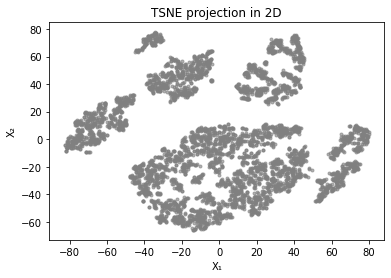

In [5]:
print("-- Manifold Learning tranformed data (without clustering)")
plt.scatter(X_transformed[:,0], 
                X_transformed[:,1], 
                c='grey',
                alpha=0.6,
                marker='.')
plt.title("TSNE projection in 2D")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()

In [6]:
means = df_person_var[load_vars['clustering_variables']].mean()
stds = df_person_var[load_vars['clustering_variables']].std()
with open("./for_standardization.csv", 'w') as file:
    pd.DataFrame(np.vstack((means, stds)), 
                 columns=load_vars['clustering_variables']).to_csv(file)

# HDBSCAN

## Training

In [6]:
MIN_CLUSTER_SIZE = 300
MIN_SAMPLES = 2

In [17]:
hdbscan_clusterer = hdbscan.HDBSCAN(metric = "euclidean", 
                            gen_min_span_tree=True,
                            min_cluster_size=MIN_CLUSTER_SIZE, 
                            min_samples=MIN_SAMPLES, 
                            prediction_data=True,
                            cluster_selection_method='leaf').fit(X)

In [18]:
dump(hdbscan_clusterer, 'HDBSCAN_leaf.joblib')

['HDBSCAN_leaf.joblib']

## Validation

In [8]:
hdbscan_labels = hdbscan_clusterer.labels_
n_clusters_ = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise_ = list(hdbscan_labels).count(-1)

X_score = X[np.where(hdbscan_labels > 0)]
labels_score = hdbscan_labels[np.where(hdbscan_labels > 0)]

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_score, labels_score))

Estimated number of clusters: 4
Estimated number of noise points: 478
Silhouette Coefficient: 0.543


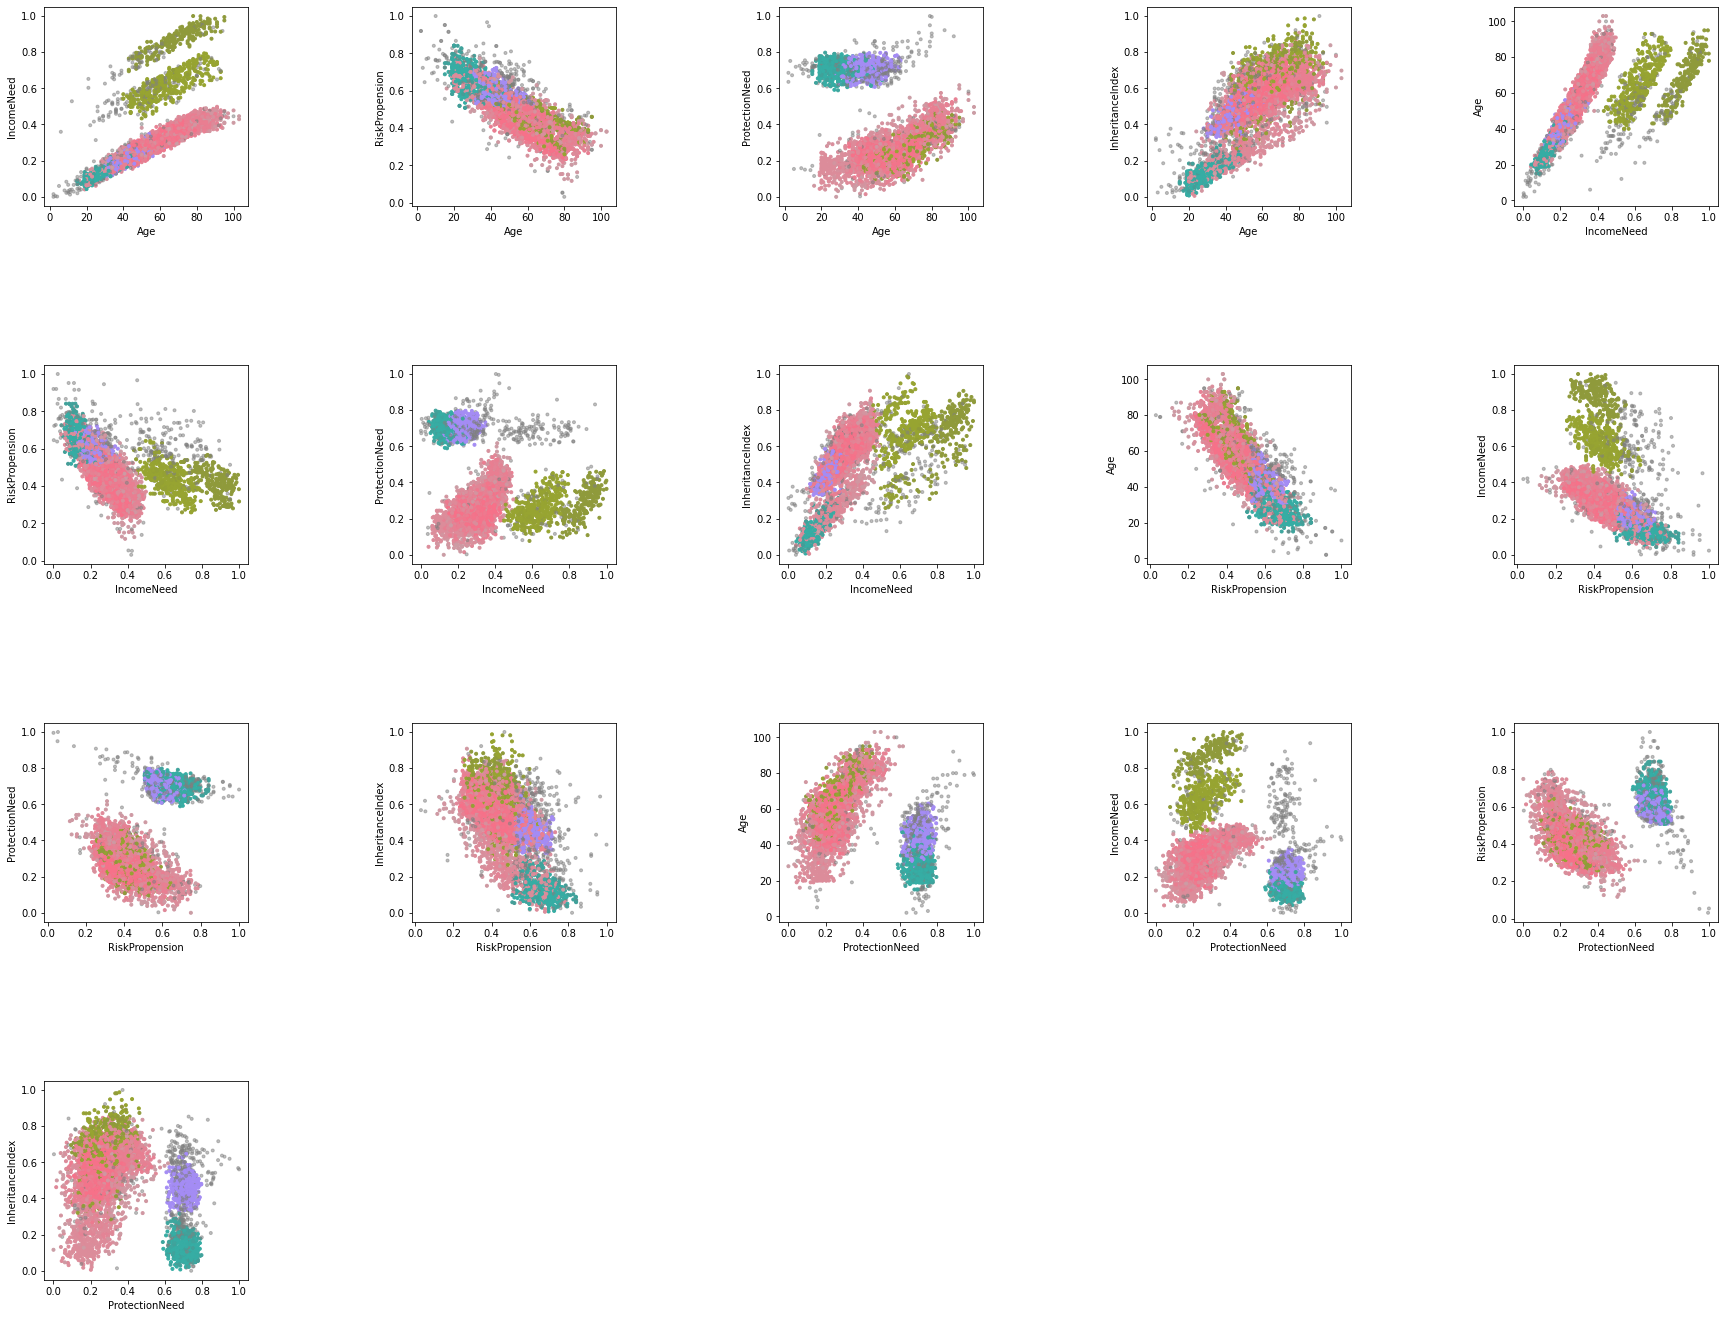

In [9]:
plot_all_vars(clusterer=hdbscan_clusterer, 
             variables=load_vars["clustering_variables"],
             data=df_person_var)

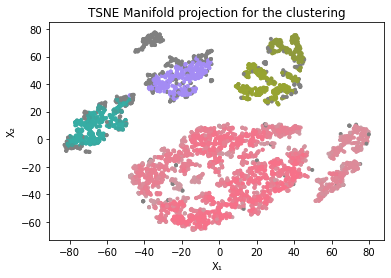

In [10]:
TSNE_manifold_plot(clusterer=hdbscan_clusterer, 
             X=X_transformed,
             transform=False, 
                   cluster_name = 'HDBSCAN_FINAL')

## Plots

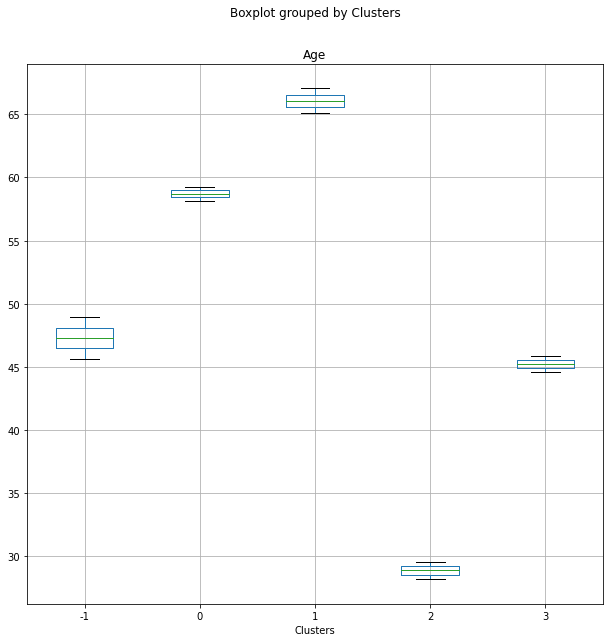

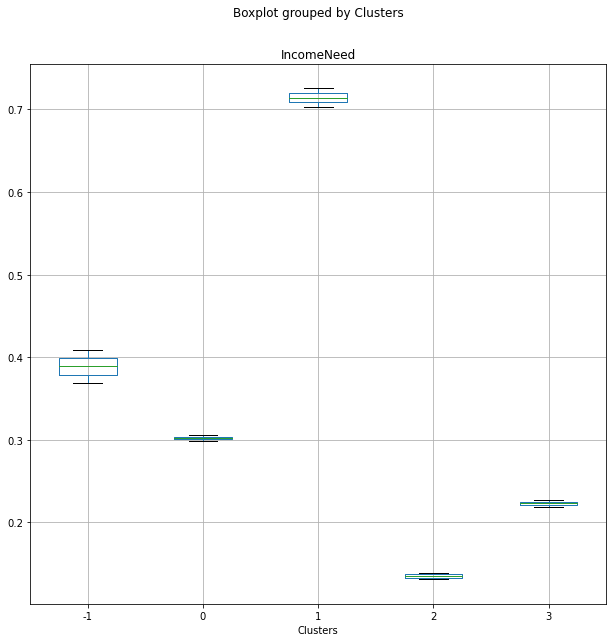

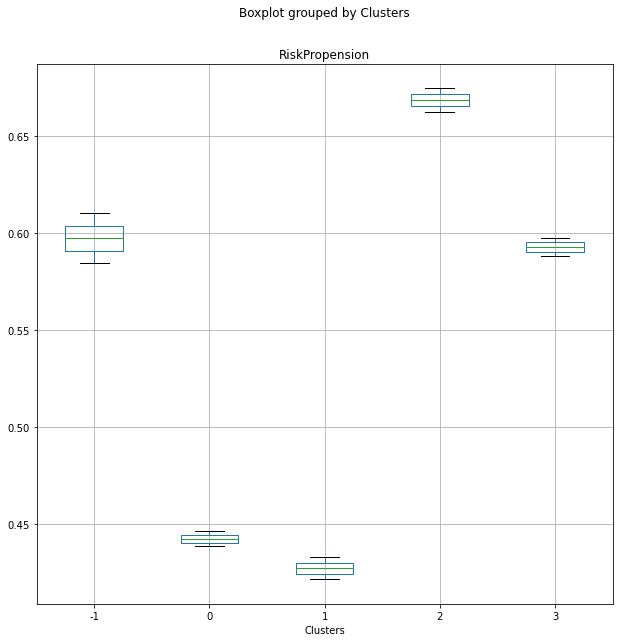

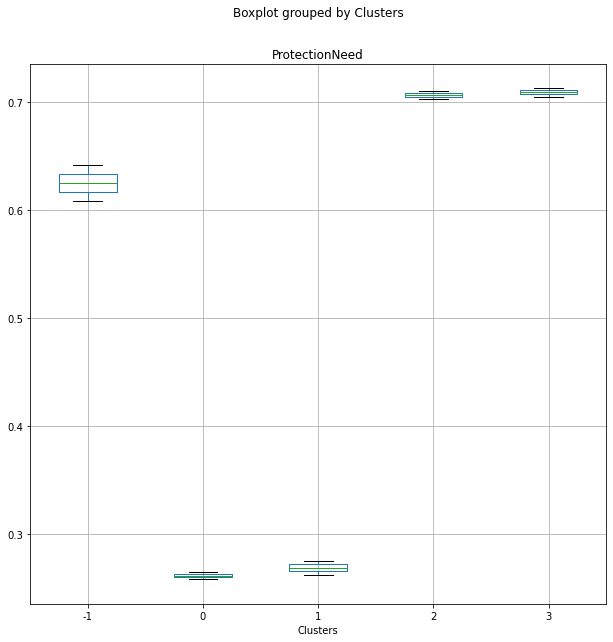

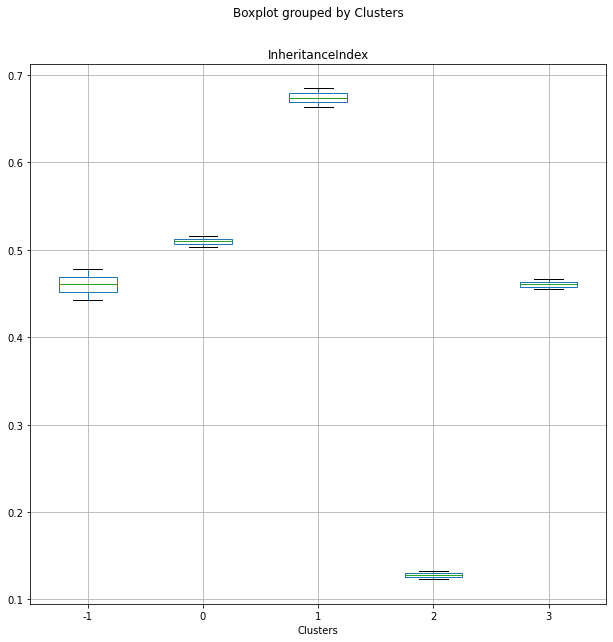

In [35]:
df_person_var["Clusters"] = hdbscan_labels

with open("dataset_with_clusters.csv", 'w') as file:
    df_person_var.to_csv(file)

avgs = df_person_var.groupby('Clusters').mean()
lower_bound = avgs - (1.96 * df_person_var.groupby('Clusters').std() / np.sqrt(df_person_var.groupby('Clusters').count()))
upper_bound = avgs + (1.96 * df_person_var.groupby('Clusters').std() / np.sqrt(df_person_var.groupby('Clusters').count()))

palette = sns.color_palette('husl', (max(df_person_var["Clusters"])+1))

box = pd.concat([avgs, lower_bound, upper_bound])
# QUESTO NON È UN BOXPLOT. SONO DEI BARPLOT
for var in load_vars['clustering_variables']:
    box.boxplot(column = var, by = 'Clusters', figsize=(10,10))
plt.show()

### General barplots

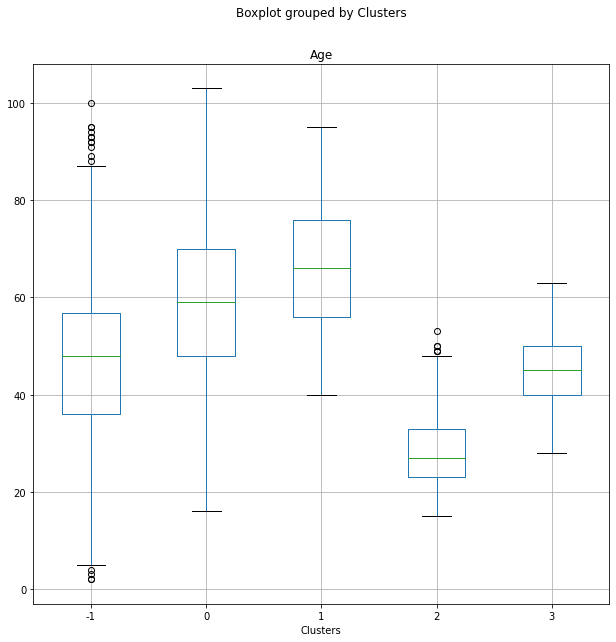

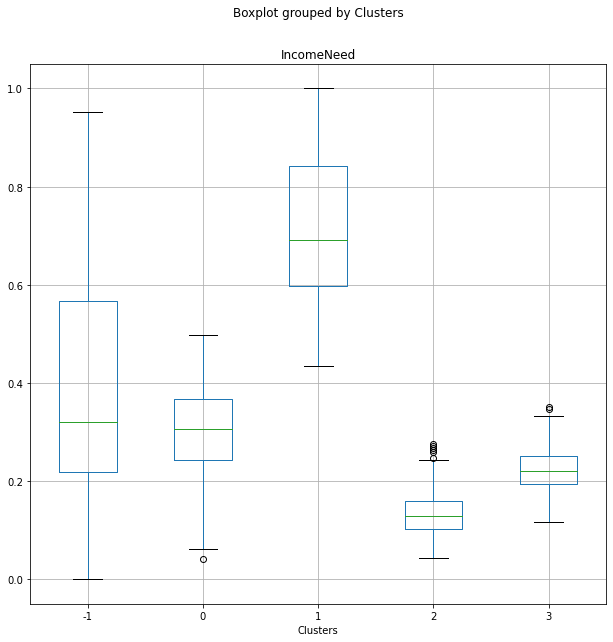

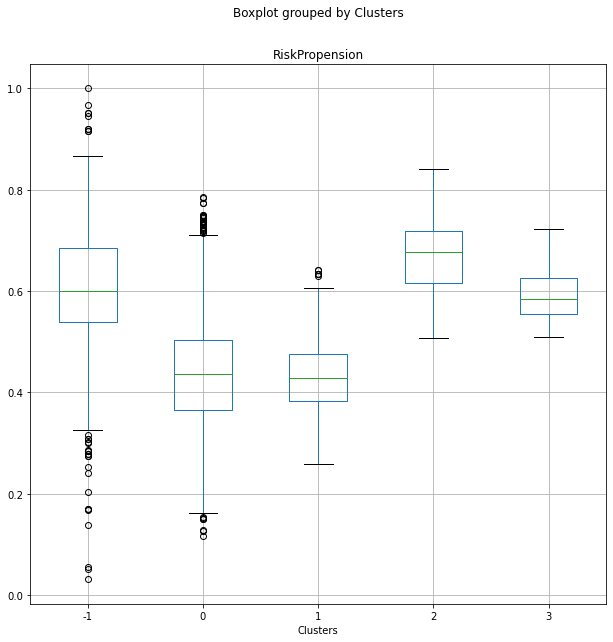

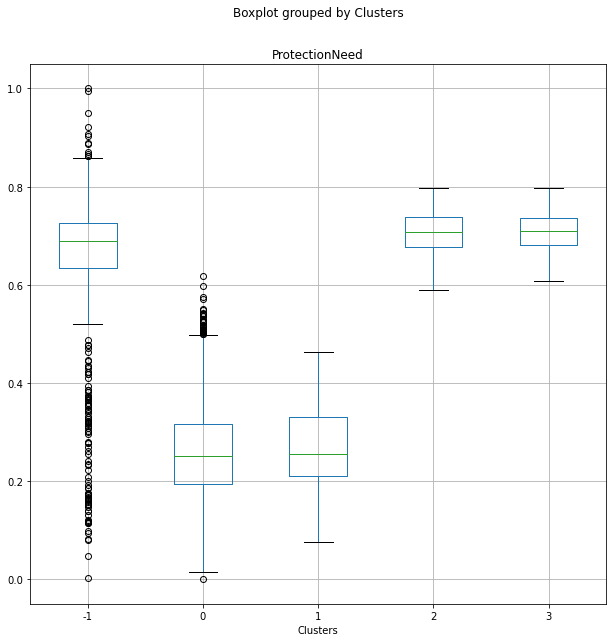

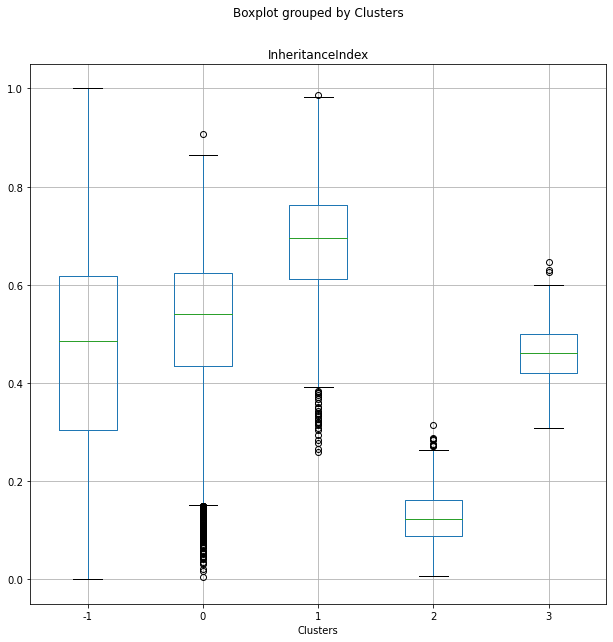

In [13]:
for var in load_vars["clustering_variables"]:
    df_person_var.boxplot(column = var, by='Clusters', figsize=(10,10))
plt.show()

### Boxplots

In [11]:
X_df = pd.DataFrame(X, columns=load_vars["clustering_variables"])
X_df['Clusters'] = hdbscan_labels
avgs_X = X_df.groupby("Clusters").mean()
avgs_X = avgs_X.reset_index()

NameError: name 'hdbscan_labels' is not defined

### Cool barplot

In [182]:
y_df = pd.DataFrame(X, 
                  columns=load_vars["clustering_variables"])
y_df["Clusters"] = hdbscan_labels


# x = load_vars['clustering_variables']
# y = list(y_df.groupby("Clusters").mean())
# err = list(y_df.groupby("Clusters").std()/5000)

In [186]:
y = list(y_df.groupby("Clusters").mean().reset_index().iloc[0,1:])
err = list(y_df.groupby("Clusters").std().reset_index().iloc[0,1:]/5000)

In [187]:
palette = sns.color_palette('husl', 4)

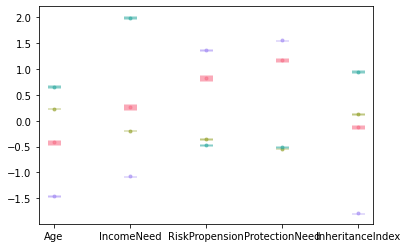

In [194]:
for i in range(4):
    y = list(y_df.groupby("Clusters").mean().reset_index().iloc[i,1:])
    err = list(y_df.groupby("Clusters").std().reset_index().iloc[i,1:]/np.sqrt(y_df.groupby("Clusters").count().reset_index().iloc[i,1:]))
    plt.errorbar(x, y, marker='.', linewidth=0, yerr = err, elinewidth=13, c=palette[i], alpha=0.6)
plt.show()

### Spider Chart

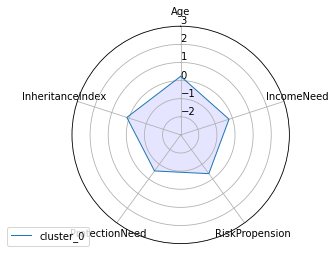

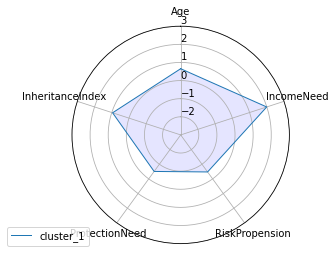

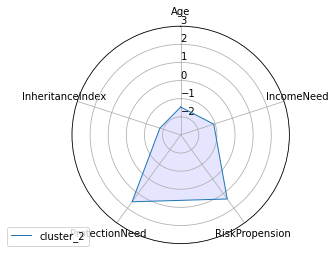

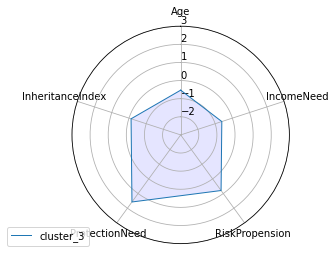

In [58]:
# number of variable
categories = load_vars["clustering_variables"]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
for cluster in range(max(hdbscan_labels)+2):
    # Ind1
    if cluster != 0:
        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories)

        # Draw ylabels
        ax.set_rlabel_position(0)
        # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
        plt.ylim(-np.array(avgs_X).max(),np.array(avgs_X).max())
        values=avgs_X.loc[cluster].drop('Clusters').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=str("cluster_"+str(cluster-1)))
        ax.fill(angles, values, 'b', alpha=0.1)
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.show()

